In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.initializers import RandomNormal, Constant

In [2]:
def img2pd(path):
    res = {"filename": [],"label": []}
    baseDir = os.path.abspath('.')
    path = os.path.join(baseDir,'train')
    for file in os.listdir(path):
        _,label,_ = file.split('-')
        res['filename'].append(file)
        res["label"].append(label)
    df = pd.DataFrame.from_dict(res)
    return df

In [3]:
df = img2pd('train')

In [4]:
train_img, valid_img = train_test_split(df, test_size = 0.15)

In [6]:
IMAGE_SIZE = 240
BATCH_SIZE = 12

In [7]:
img_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                               fill_mode = 'nearest', rotation_range = 10, width_shift_range = 0.2,
                               height_shift_range= 0.2, shear_range= 0.15, brightness_range= (.5,1.2),
                               zoom_range = 0.2)
train = img_gen.flow_from_dataframe(train_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                    target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                    batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)
val = img_gen.flow_from_dataframe(valid_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 4807 validated image filenames belonging to 5 classes.
Found 849 validated image filenames belonging to 5 classes.


In [8]:
def create_model():
    
    model = Sequential()
    model.add(ResNet50(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, 
                             weights='imagenet'))
    model.add(GlobalAveragePooling2D())
#     BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
#         gamma_initializer=Constant(value=0.9))
    model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
#     BatchNormalization(momentum=0.95, epsilon=0.005,beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
#                        gamma_initializer=Constant(value=0.9))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
EPOCHS = 30
STEP_SIZE_TRAIN = train.n // train.batch_size
STEP_SIZE_TEST = val.n // val.batch_size

In [10]:
def model_fit(train,val):
    model = create_model()
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=1e-3)
    
    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss, metrics = ['categorical_accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
    checkpoint_cb = ModelCheckpoint("ResNet_best.h5",save_best_only=True,monitor='val_loss',mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,mode='min',verbose=1)
    history = model.fit(train,validation_data=val,epochs=EPOCHS,batch_size=BATCH_SIZE,
                        steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_TEST,
                        callbacks=[es,checkpoint_cb, reduce_lr])
    model.save('ResNet'+'.h5')  
    
    return history

In [11]:
with tf.device('/GPU:0'):
    results = model_fit(train,val)
    print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
    print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/30
400/400 [==============================] - 172s 389ms/step - loss: 1.5607 - categorical_accuracy: 0.4790 - val_loss: 1.5424 - val_categorical_accuracy: 0.2560
Epoch 2/30
400/400 [==============================] - 155s 388ms/step - loss: 1.1992 - categorical_accuracy: 0.5619 - val_loss: 2.7734 - val_categorical_accuracy: 0.2655
Epoch 3/30
400/400 [==============================] - 153s 381ms/step - loss: 1.1354 - categorical_accuracy: 0.5936 - val_loss: 1.1708 - val_categorical_accuracy: 0.5857
Epoch 4/30
400/400 [==============================] - 152s 380ms/step - loss: 1.0821 - categorical_accuracy: 0.6023 - val_loss: 1.4105 - val_categorical_accuracy: 0.5869
Epoch 5/30
400/400 [==============================] - 152s 379ms/step - loss: 1.0600 - categorical_accuracy: 0.6284 - val_loss: 1.3367 - val_categorical_accuracy: 0.5810

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/30
400/400 [==============================] - 152s 380ms/ste

In [14]:
def train_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()

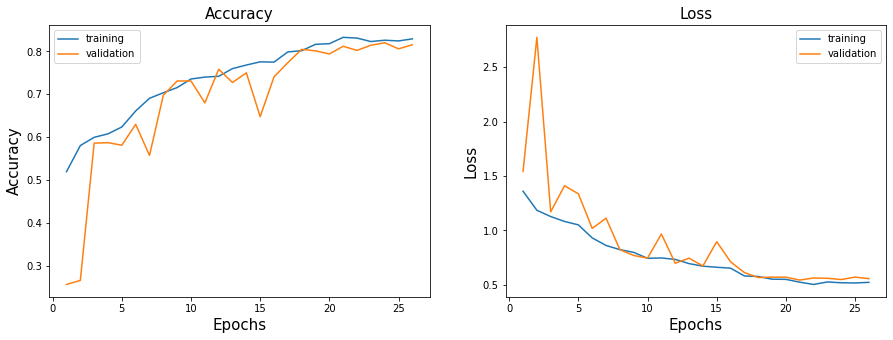

In [15]:
train_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)